# Alloy4Fun Data

In [21]:
import pandas as pd, os 
import matplotlib.pyplot as plt
import collections
import jpype # Java
import re # Regular expression

## Import Data

In [22]:
def importDataFromDir(dir):
    # Import all the data from a directory
    # dir: directory with the data
    # return: a dictionary of dataframes
    dict = {}

    for file in os.listdir(dir):
        if file.endswith('.json'):
            df = pd.read_json(f'{dir}/' + file, lines=True)
            dict[file.removesuffix(".json")] = df
            print(f"Imported {file}.")

    return dict

def removeFile(file):
    # Remove the log file
    try:
        os.remove(file)
    except OSError:
        pass

# Remove the log file if exists
os.makedirs("logs", exist_ok=True)
log_file_ast = "logs/astError.txt"
log_file_drops = "logs/drops.txt"
removeFile(log_file_ast)
removeFile(log_file_drops)

# Import files from the data directory
dict = importDataFromDir('datasets/submissions')

Imported 9jPK8KBWzjFmBx4Hb.json.
Imported aTwuoJgesSd8hXXEP.json.
Imported bNCCf9FMRZoxqobfX.json.
Imported dkZH6HJNQNLLDX6Aj.json.
Imported FwCGymHmbqcziisH5.json.
Imported gAeD3MTGCCv8YNTaK.json.
Imported JC8Tij8o8GZb99gEJ.json.
Imported JDKw8yJZF5fiP3jv3.json.
Imported jyS8Bmceejj9pLbTW.json.
Imported PQAJE67kz8w5NWJuM.json.
Imported PSqwzYAfW9dFAa9im.json.
Imported QxGnrFQnXPGh2Lh8C.json.
Imported sDLK7uBCbgZon3znd.json.
Imported WGdhwKZnCu7aKhXq9.json.
Imported YH3ANm7Y5Qe5dSYem.json.
Imported zoEADeCW2b2suJB2k.json.
Imported zRAn69AocpkmxXZnW.json.


## Data Cleaning

### Separate challenge code from the rest of submissions

In [23]:
def separateChallengeRows(dict):
    # Separate the original row of each dataframe
    # dict: dictionary of dataframes
    # return: a dictionary of dataframes
    challengeRows = {}

    for key, df in dict.items():
        # Store the index of the original row of each dataframe
        index = df[df["_id"] == key].index.values.astype(int)[0]
        row = df.iloc[index]
        # store the original row in a new dataframe
        challengeRows[key] = pd.DataFrame([row.values], columns=row.index)
        # Remove the original row from the dataframe
        df.drop(index=index, inplace=True)

    return challengeRows

challengeRows = separateChallengeRows(dict) 

# Check
challengeRows["9jPK8KBWzjFmBx4Hb"].head()

,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme
0,9jPK8KBWzjFmBx4Hb,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,cAMmPjLAFceP7dnod,9jPK8KBWzjFmBx4Hb,NaN,2019-10-31 10:28:19,NaN,"{'currentFramePosition': {}, 'currentlyProject..."


### Check null values

In [24]:
df1 = dict["9jPK8KBWzjFmBx4Hb"]
df1.isnull().sum()

_id                0
cmd_c            926
cmd_i             36
cmd_n            926
code               0
derivationOf       0
original           0
sat               36
time               0
msg             4368
theme           5242
dtype: int64

Features meaning:
- _id: the id of the interaction
- time: the timestamp of its creation
- derivationOf: the parent entry
- original: the first ancestor with secrets (always the same within an exercise)
- code: the complete code of the model (excluding the secrets defined in the original entry) (with student comments removed)
- sat: whether the command was satisfiable (counter-example found for checks), or -1 when error thrown [only for executions]
- cmd_i: the index of the executed command [only for executions]
- cmd_n: the name of the executed command [only for successful executions, i.e. no error thrown]
- cmd_c: whether the command was a check [only for successful executions, i.e. no error thrown]
- msg: the error or warning message [only for successful executions with warnings or when error thrown]
- theme: the visualisation theme [only for sharing entries

#### cmd_i null values

cmd_i is null for non-executions. 

In [25]:
# Filter rows with cmd_i = null
nullDF = df1[df1["cmd_i"].isnull()]
nullDF.head()

,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme
32,P3gFuEkajduWTyFeo,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,6YmxWkc8PtXEqdafi,9jPK8KBWzjFmBx4Hb,NaN,2019-10-31 11:47:23,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
159,K2ejbWj7HT3mSFdym,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,4zDygwoYWF7AAqHv8,9jPK8KBWzjFmBx4Hb,NaN,2020-1-3 13:48:36,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
210,2MPKwEJXDud4Ro8Ka,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,9jPK8KBWzjFmBx4Hb,9jPK8KBWzjFmBx4Hb,NaN,2022-2-1 18:47:26,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
302,MdZs9uee25QgFwvi7,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,kb8KrpANCxg9XXcLs,9jPK8KBWzjFmBx4Hb,NaN,2019-10-31 11:48:12,NaN,"{'currentFramePosition': {}, 'currentlyProject..."
338,fWKpSLkdPZPxkSoJe,NaN,NaN,NaN,/**\n * Linear temporal logic revision exercis...,8KGv5F6b8ySPofNdJ,9jPK8KBWzjFmBx4Hb,NaN,2019-10-31 11:52:15,NaN,"{'currentFramePosition': {}, 'currentlyProject..."


In [26]:
print("Rows with cmd_i null: ", len(nullDF))
print("Rows with sat null: ", len(nullDF[nullDF["sat"].isnull()]))
print("Rows with cmd_c null : ", len(nullDF[nullDF["cmd_c"].isnull()]))
print("Rows with cmd_n null : ", len(nullDF[nullDF["cmd_n"].isnull()]))
print("Rows with theme null : ", len(nullDF[nullDF["theme"].isnull()]))

Rows with cmd_i null:  36
Rows with sat null:  36
Rows with cmd_c null :  36
Rows with cmd_n null :  36
Rows with theme null :  0


Whenever cmd_i is null it means that there was no execution. It is the sharing of a model. This cases might be irrelevant to the problem so they can be dropped.

In [27]:
def logDrop(id, reason):
    # Log an error
    # id: id of the submission
    # challenge: id of the challenge
    # error: error message
    # expr: expression that failed
    file = open(log_file_drops, "a")
    file.write("DROPPED " + id + " FOR " + reason + "\n")
    file.close()

def shortCircuit(df, index):
    # Short circuit the derivation of a row.
    # If A derives B and B derives C, then A derives C and B is removed.
    # df: dataframe
    # index: index of the row to be removed
    # return: dataframe with the row short circuited

    # Get row information
    row = df.loc[[index]]
    id = row["_id"].values[0]
    derivation = row["derivationOf"].values[0]

    # Remove row
    df.drop(index, inplace=True)

    # Short circuit derivations
    df.loc[df["derivationOf"] == id, "derivationOf"] = derivation

    return df

def dropNulls(dict, col):
    # Remove rows with col null
    # dict: dictionary of dataframes
    # return: dataframe with rows with col null removed
    total = 0
    for challengeID, df in dict.items():
        # Filter rows with col= null
        nullDF = df[df[col].isnull()]
        # Short circuit derivations
        for index, row in nullDF.iterrows():
            df = shortCircuit(df, index)
            logDrop(row["_id"], "having null " + col)
            total += 1            
    print(f"Total number of rows dropped: {total}")
    return dict


# Drop rows with cmd_i null
dict = dropNulls(dict, "cmd_i")
# Check results
df1 = dict["9jPK8KBWzjFmBx4Hb"]
nullDF = df1[df1["cmd_i"].isnull()]
nullDF.head()


Total number of rows dropped: 1342


,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme


#### cmd_c and cmd_n null values

In [28]:
# Filter rows with cmd_c = null
nullDF = df1[df1["cmd_c"].isnull()]
nullDF.head()

,_id,cmd_c,cmd_i,cmd_n,code,derivationOf,original,sat,time,msg,theme
13,nuWnon2d7N7N7ZFvw,NaN,7.0,NaN,/**\n * Linear temporal logic revision exercis...,ZjxPhwuLGd52cZyox,9jPK8KBWzjFmBx4Hb,-1.0,2020-11-23 23:09:43,There are 1 possible tokens that can appear he...,NaN
14,sxuHvWgfPeRh9QYYy,NaN,7.0,NaN,/**\n * Linear temporal logic revision exercis...,RBovdMdE7s7k2Z3xY,9jPK8KBWzjFmBx4Hb,-1.0,2020-12-1 21:46:47,There are 37 possible tokens that can appear h...,NaN
16,xPeTe3FdpxzspZTta,NaN,7.0,NaN,/**\n * Linear temporal logic revision exercis...,t45BxKKpdXbYN4Aun,9jPK8KBWzjFmBx4Hb,-1.0,2020-11-26 10:17:06,There are 1 possible tokens that can appear he...,NaN
20,GQbQyxLarysc73gH7,NaN,3.0,NaN,/**\n * Linear temporal logic revision exercis...,2js6dSN2dk4HhJmbF,9jPK8KBWzjFmBx4Hb,-1.0,2020-12-1 11:39:04,There are 37 possible tokens that can appear h...,NaN
25,CCt6wniT5St2hKKFr,NaN,0.0,NaN,/**\n * Linear temporal logic revision exercis...,9jPK8KBWzjFmBx4Hb,9jPK8KBWzjFmBx4Hb,-1.0,2019-10-31 10:48:50,There are 29 possible tokens that can appear h...,NaN


In [29]:
print("Rows with cmd_c null: ", len(nullDF))
print("Rows with cmd_n null: ", len(nullDF[nullDF["cmd_n"].isnull()]))
print("Rows with msg null: ", len(nullDF[nullDF["msg"].isnull()]))
print("Rows with negative sat: ", len(nullDF[nullDF["sat"] == -1]))

Rows with cmd_c null:  890
Rows with cmd_n null:  890
Rows with msg null:  0
Rows with negative sat:  890


Whenever cmd_c is null, cmd_n is also null. These values are null for cases where a syntactic error is thrown and a msg appears.
The code in these case is not parseable. We can drop these rows.

In [30]:
# drop rows with cmd_c null
dict = dropNulls(dict, "cmd_c")
# Check results
dict["9jPK8KBWzjFmBx4Hb"].isnull().sum()

Total number of rows dropped: 28066


_id                0
cmd_c              0
cmd_i              0
cmd_n              0
code               0
derivationOf       0
original           0
sat                0
time               0
msg             4332
theme           4352
dtype: int64

Dealing with mgs and theme null values is not important in these context.

### Remove extra features

#### cmd_c feature

Counter({1.0: 68284, 0.0: 46})


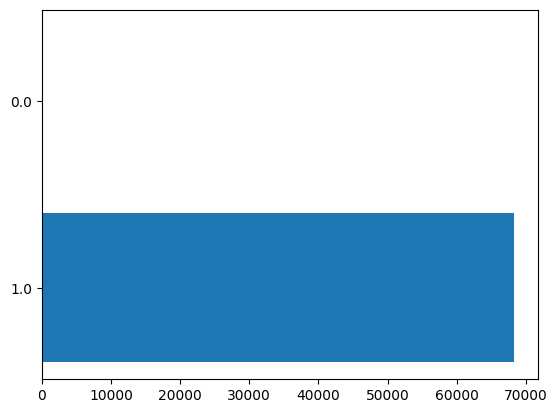

In [31]:
def countValues(dict, col):
    # Count the values in a column
    # df: dataframe
    # col: column to count
    # return: dataframe with the counts
    totalCount = collections.Counter()

    for df in dict.values():
        count = df[col].value_counts().to_dict()
        totalCount.update(count)        

    return totalCount

# Count the different values in the cmd_c column across all the dataframes
counter = countValues(dict, 'cmd_c')
print(counter)

plt.barh([str(k) for k in counter.keys()], counter.values())
plt.show()


The number of 0 values for the column cmd_c is irrelevant (when the executed command is not a check). For that reason, entries with these values should be dropped.

In [32]:
def dropNonChecks(dict):
    # Drop the rows that are not checks
    # dict: dictionary of dataframes
    # return: dataframe with the rows that are not checks removed
    total = 0
    for df in dict.values():
        # Filter rows with cmd_c != 0
        dfToDrop = df[df["cmd_c"] == 0]
        # Short circuit derivations
        for index, row in dfToDrop.iterrows():
            df = shortCircuit(df, index)
            logDrop(row["_id"], "being a non check (cmd_c = 0)")
            total += 1
    print(f"Total number of rows dropped: {total}")
    return dict

# Remove the rows with the value 0 in the cmd_c column
dropNonChecks(dict)

# Check
print(countValues(dict, 'cmd_c'))

Total number of rows dropped: 46
Counter({1.0: 68284})


#### original feature

In [33]:
def operateDFs(dict, op, arg):
    # Operate on each dataframe in a dictionary
    # dict: dictionary of dataframes
    # op: operation to perform
    # arg: argument to pass to the operation
    for df in dict.values():
        op(df, arg)

# Count the different values for the original column for each dataframe
countValuesOp = (lambda df, arg: print(df[arg].value_counts().to_dict()))
operateDFs(dict, countValuesOp, 'original')

{'9jPK8KBWzjFmBx4Hb': 4352}
{'aTwuoJgesSd8hXXEP': 2392}
{'bNCCf9FMRZoxqobfX': 3660}
{'dkZH6HJNQNLLDX6Aj': 14934}
{'FwCGymHmbqcziisH5': 982}
{'gAeD3MTGCCv8YNTaK': 2476}
{'JC8Tij8o8GZb99gEJ': 854}
{'JDKw8yJZF5fiP3jv3': 5055}
{'jyS8Bmceejj9pLbTW': 600}
{'PQAJE67kz8w5NWJuM': 3056}
{'PSqwzYAfW9dFAa9im': 9851}
{'QxGnrFQnXPGh2Lh8C': 6388}
{'sDLK7uBCbgZon3znd': 2709}
{'WGdhwKZnCu7aKhXq9': 283}
{'YH3ANm7Y5Qe5dSYem': 4374}
{'zoEADeCW2b2suJB2k': 2072}
{'zRAn69AocpkmxXZnW': 4246}


Every dataframe has the same value for the original column. This column is irrelevant.

Now we will drop the irrelevant columns. 

In [34]:
# Drop columns that are not needed
dropColOp = (lambda df, arg: df.drop(columns=arg, axis=1, inplace=True))
colsToDrop = ["cmd_c", "cmd_i", "original", "msg", "theme"]

operateDFs(dict, dropColOp, colsToDrop)
operateDFs(challengeRows, dropColOp, colsToDrop) 

dict["9jPK8KBWzjFmBx4Hb"].head()

,_id,cmd_n,code,derivationOf,sat,time
0,zKAYz8BCDmHKgNoSx,prop8Ok,/**\n * Linear temporal logic revision exercis...,dvhCng5AdxC8MqjFy,1.0,2020-12-13 23:28:11
1,8FmQ9PNWT2SXncTxX,prop10Ok,/**\n * Linear temporal logic revision exercis...,5eT7wTw5kT8DwTbu2,1.0,2019-11-11 21:54:33
2,eyGu5DYCrnk58G2fJ,prop7Ok,/**\n * Linear temporal logic revision exercis...,niLmMRmm94Hz6ymcD,1.0,2020-12-1 11:55:11
3,Akbr9Aq6WfBLHrvE8,prop19Ok,/**\n * Linear temporal logic revision exercis...,DnAm62D7JaqDzyy5y,1.0,2020-11-26 10:33:29
4,MNegade3hLiutxCru,prop11Ok,/**\n * Linear temporal logic revision exercis...,cjK4u23ZAfYm8fatA,1.0,2020-1-19 17:06:22


### Code cleaning

The code in this dataset comes with comments that can be removed.

In [35]:
def cleanCode(code):
    # Remove comments and empty lines
    # code: string with the code
    # return: string with the code without comments and empty lines
    code = re.sub(r"(/\*(.|\n)*?\*/)|(//.*)|(--.*)", "", code) # remove comments
    code = re.sub(r"\n\n(?=\n)", "", code) # remove empty lines
    code = code.replace("\n", " ").replace("\t", " ")
    
    return " ".join(code.split()).strip()

def applyToCol(df, col, op):
    # Apply an operation to a column
    # df: dataframe
    # col: column to apply the operation
    # op: operation to apply
    # return: dataframe with the operation applied
    df[col] = df[col].apply(op)
    return df

# Clean the code column
cleanCodeOp = (lambda df, arg: applyToCol(df, arg, cleanCode))
operateDFs(dict, cleanCodeOp, "code")
operateDFs(challengeRows, cleanCodeOp, "code")

df1.head()


,_id,cmd_n,code,derivationOf,sat,time
0,zKAYz8BCDmHKgNoSx,prop8Ok,var sig File { var link : lone File } var sig ...,dvhCng5AdxC8MqjFy,1.0,2020-12-13 23:28:11
1,8FmQ9PNWT2SXncTxX,prop10Ok,var sig File { var link : lone File } var sig ...,5eT7wTw5kT8DwTbu2,1.0,2019-11-11 21:54:33
2,eyGu5DYCrnk58G2fJ,prop7Ok,var sig File { var link : lone File } var sig ...,niLmMRmm94Hz6ymcD,1.0,2020-12-1 11:55:11
3,Akbr9Aq6WfBLHrvE8,prop19Ok,var sig File { var link : lone File } var sig ...,DnAm62D7JaqDzyy5y,1.0,2020-11-26 10:33:29
4,MNegade3hLiutxCru,prop11Ok,var sig File { var link : lone File } var sig ...,cjK4u23ZAfYm8fatA,1.0,2020-1-19 17:06:22


### cmd_n rename

Rename cmd_n so that it equals the predicate completed by the student.

In [36]:
def removeExtraSuffix(pred):
    return re.sub("OK|Ok|ok", "", pred)

remSuffixOp = (lambda df, arg: applyToCol(df, arg, removeExtraSuffix))
operateDFs(dict, remSuffixOp, "cmd_n")

df1.head()

,_id,cmd_n,code,derivationOf,sat,time
0,zKAYz8BCDmHKgNoSx,prop8,var sig File { var link : lone File } var sig ...,dvhCng5AdxC8MqjFy,1.0,2020-12-13 23:28:11
1,8FmQ9PNWT2SXncTxX,prop10,var sig File { var link : lone File } var sig ...,5eT7wTw5kT8DwTbu2,1.0,2019-11-11 21:54:33
2,eyGu5DYCrnk58G2fJ,prop7,var sig File { var link : lone File } var sig ...,niLmMRmm94Hz6ymcD,1.0,2020-12-1 11:55:11
3,Akbr9Aq6WfBLHrvE8,prop19,var sig File { var link : lone File } var sig ...,DnAm62D7JaqDzyy5y,1.0,2020-11-26 10:33:29
4,MNegade3hLiutxCru,prop11,var sig File { var link : lone File } var sig ...,cjK4u23ZAfYm8fatA,1.0,2020-1-19 17:06:22


# Feature Engineering

## Year column 

Extract year from time column.

In [37]:
dict["9jPK8KBWzjFmBx4Hb"].head()

,_id,cmd_n,code,derivationOf,sat,time
0,zKAYz8BCDmHKgNoSx,prop8,var sig File { var link : lone File } var sig ...,dvhCng5AdxC8MqjFy,1.0,2020-12-13 23:28:11
1,8FmQ9PNWT2SXncTxX,prop10,var sig File { var link : lone File } var sig ...,5eT7wTw5kT8DwTbu2,1.0,2019-11-11 21:54:33
2,eyGu5DYCrnk58G2fJ,prop7,var sig File { var link : lone File } var sig ...,niLmMRmm94Hz6ymcD,1.0,2020-12-1 11:55:11
3,Akbr9Aq6WfBLHrvE8,prop19,var sig File { var link : lone File } var sig ...,DnAm62D7JaqDzyy5y,1.0,2020-11-26 10:33:29
4,MNegade3hLiutxCru,prop11,var sig File { var link : lone File } var sig ...,cjK4u23ZAfYm8fatA,1.0,2020-1-19 17:06:22


In [38]:
def extractYear(date):
    # Extract the year and month from a date
    # date: string with the date
    # return: int with the year * 100 + month

    # Check if the date is in the format YYYY-MM-DD hh:mm:ss
    if "-" in date:
        return int(date[:4]) * 100 + int(date[5:7].replace("-", ""))
    else: # date is in the format DD/MM/YYYY, hh:mm:ss PM
        split = date.split(",")[0].split("/")
        return int(split[2]) * 100 + int(split[1])

# Extract the year from the date column
extractYearOp = (lambda df, arg: applyToCol(df, arg, extractYear))
operateDFs(dict, extractYearOp, "time")
operateDFs(challengeRows, extractYearOp, "time")



## Expression column

Import Java library.

In [39]:
# Import the Java libraries
if not jpype.isJVMStarted():
    jpype.startJVM(classpath=['../lib/org/higena/higena/1.0.0/higena-1.0.0.jar'])

# Import the Java classes
CompUtil = jpype.JClass('edu.mit.csail.sdg.parser.CompUtil')
Reporter = jpype.JClass('edu.mit.csail.sdg.alloy4.A4Reporter')

Generate Expr column that contains the expression written by the student to the respective predicate.

In [40]:
# Import the Java classes
ExprParser = jpype.JClass('org.higena.parser.ExprExtractor')
def getExpr(code: str, cmd: str):
    # Get the expression of a predicate
    # code: string with the code
    # cmd: predicate name
    # return: string with the expression of the predicate
    parser = ExprParser(code)
    return str(parser.parse(cmd)).strip()

def genExprColum(dict):
    # Iterate datasets 
    for df in dict.values():
        df["expr"] = df.apply(lambda x: getExpr(x["code"], x["cmd_n"]), axis=1)

genExprColum(dict)

In [41]:
# Check the results
dict["9jPK8KBWzjFmBx4Hb"].head()

,_id,cmd_n,code,derivationOf,sat,time,expr
0,zKAYz8BCDmHKgNoSx,prop8,var sig File { var link : lone File } var sig ...,dvhCng5AdxC8MqjFy,1.0,202012,
1,8FmQ9PNWT2SXncTxX,prop10,var sig File { var link : lone File } var sig ...,5eT7wTw5kT8DwTbu2,1.0,201911,always all f:File | f in Protected implies f i...
2,eyGu5DYCrnk58G2fJ,prop7,var sig File { var link : lone File } var sig ...,niLmMRmm94Hz6ymcD,1.0,202012,always some Protected
3,Akbr9Aq6WfBLHrvE8,prop19,var sig File { var link : lone File } var sig ...,DnAm62D7JaqDzyy5y,1.0,202011,always (all f : File | f in Protected until f ...
4,MNegade3hLiutxCru,prop11,var sig File { var link : lone File } var sig ...,cjK4u23ZAfYm8fatA,1.0,202001,File - Protected in Protected'


## Add challenge code to dataset

Add submissions to the dataset that represent the initial state of the challenge (the empty submission) and the teacher's solution.

In [42]:
def genEmptySubmission(challengeDf): 
    # Generate an empty submission
    # challengeDf: dataframe with one row with the challenge
    # return: dataframe with one row with the empty submission for the challenge

    challengeRow = challengeDf # Copy the dictionary
    challengeRow["sat"] = [1.0] # Empty submission is incorrect
    challengeRow["expr"] = ["EMPTY"] # Empty submission has an empty expression
    challengeRow["derivationOf"] = [""] # Does not derive from any other challenge

    return challengeRow

def getSolutions(code):
    # Get the solutions of a challenge
    # code: string with the code
    # return: dictionary with the solutions where the key is the predicate name and the value is the solution expression

    result = {} # Initialize dictionary
    module = CompUtil.parseEverything_fromString(Reporter(), code)

    # Set keys of the dictionary: predicates to be completed by students (empty predicates)
    for fun in module.getAllFunc():
        if "$$Default" not in fun.label and fun.getBody().toString().equals("true"): # Empty predicate has the body "true"
            result[str(fun.label).removeprefix("this/")] = "" 

    # Get the solutions
    for fun in module.getAllFunc():
        label = str(fun.label).removeprefix("this/")
        if label in result: # Skip if predicate in dictionary
            continue

        # Check for variations of 'oracle' in label
        possible_keys = [label.removesuffix(suffix) for suffix in ["o", "O", "oracle"] if label.endswith(suffix)]
        for key in possible_keys:
            if key in result:
                result[key] = getExpr(code, label)
                break

    return result

def addChallengeRows(dict, challengeRows):
    # Add the challenge rows 
    # dict: dictionary of dataframes
    # challengeRows: dictionary of dataframes with the challenge rows
    # return: dictionary of dataframes with the challenge rows added
    total = 0 # Initialize total number of rows

    # Iterate datasets
    for challenge in dict.keys():
        # Get the initial empty submission for the challenge and set its fields 
        challenge_row = genEmptySubmission(challengeRows[challenge])
        # Get the solutions of the challenge
        challenge_solutions = getSolutions(challenge_row["code"].values[0])

        # Gen the teacher solution
        solution_row = challenge_row.copy()
        solution_row["sat"] = [0.0] # Correct
        solution_row["derivationOf"] = [challenge]

        for pred, solution in challenge_solutions.items():
            # Set up and append the challenge empty row to the dataframe
            challenge_row["cmd_n"] = [pred]
            dict[challenge] = pd.concat([dict[challenge], challenge_row], ignore_index=True)

            # Set up and append the teacher solution row to the dataframe
            solution_row["expr"] = [solution] 
            solution_row["cmd_n"] = [pred]
            solution_row["_id"] = ["sol_" + pred]
            dict[challenge] = pd.concat([dict[challenge], solution_row], ignore_index=True)
            # Update total number of rows
            total += 2
    
    print("Total number of rows added: " + str(total))
    return dict

dict = addChallengeRows(dict, challengeRows)

Total number of rows added: 366


In [43]:
# Check
df = dict["9jPK8KBWzjFmBx4Hb"]
df[df["expr"] == "EMPTY"].head()

,_id,cmd_n,code,derivationOf,sat,time,expr
4352,9jPK8KBWzjFmBx4Hb,prop1,var sig File { var link : lone File } var sig ...,,1.0,201910,EMPTY
4354,9jPK8KBWzjFmBx4Hb,prop2,var sig File { var link : lone File } var sig ...,,1.0,201910,EMPTY
4356,9jPK8KBWzjFmBx4Hb,prop3,var sig File { var link : lone File } var sig ...,,1.0,201910,EMPTY
4358,9jPK8KBWzjFmBx4Hb,prop4,var sig File { var link : lone File } var sig ...,,1.0,201910,EMPTY
4360,9jPK8KBWzjFmBx4Hb,prop5,var sig File { var link : lone File } var sig ...,,1.0,201910,EMPTY


In [44]:
df[df["_id"] == "sol_prop1"]

,_id,cmd_n,code,derivationOf,sat,time,expr
4353,sol_prop1,prop1,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,0.0,201910,no Trash+Protected


## Remove Empty Submissions

Remove submissions with empty expression except for the inital submission.

In [45]:
def dropEmptySubmissions(dict):
    # Drop rows that are empty submissions
    # dict: dictionary of dataframes
    # return: dataframe without empty submissions
    total = 0
    for df in dict.values():
        # Filter rows with expr = ""
        rowsToDrop = df[df["expr"] == ""]
        # Short circuit derivations
        for index, row in rowsToDrop.iterrows():
            df = shortCircuit(df, index)
            logDrop(row["_id"], "being an empty submission.")
            total += 1
    print("Total empty submissions dropped: " + str(total))

def fixEmpty(expr):
    # Turn EMPTY expr to ""
    # expr: string with the expression
    # return: string with the expression fixed
    if expr == "EMPTY":
        return ""
    else:
        return expr

dropEmptySubmissions(dict)
# Turn EMPTY expr to "" 
fixEmptyOp = (lambda df, arg: applyToCol(df, arg, fixEmpty))
operateDFs(dict, fixEmptyOp, "expr")



Total empty submissions dropped: 2205


In [46]:
# Check
df = dict["9jPK8KBWzjFmBx4Hb"]
df[df["expr"] == ""].head()

,_id,cmd_n,code,derivationOf,sat,time,expr
4352,9jPK8KBWzjFmBx4Hb,prop1,var sig File { var link : lone File } var sig ...,,1.0,201910,
4354,9jPK8KBWzjFmBx4Hb,prop2,var sig File { var link : lone File } var sig ...,,1.0,201910,
4356,9jPK8KBWzjFmBx4Hb,prop3,var sig File { var link : lone File } var sig ...,,1.0,201910,
4358,9jPK8KBWzjFmBx4Hb,prop4,var sig File { var link : lone File } var sig ...,,1.0,201910,
4360,9jPK8KBWzjFmBx4Hb,prop5,var sig File { var link : lone File } var sig ...,,1.0,201910,


## Separate DFs by predicate

Parse the challenge files first.

In [47]:
def parseChallenges(path):
    # Parse the challenges
    # path: path to the challenges
    # return: dictionary of parsed challenges with the name as key 
    challenges = {}
    for challenge in os.listdir(path):
        if challenge.endswith(".als"):
            challenges[challenge[:-4]] = CompUtil.parseEverything_fromFile(Reporter(), None, path + challenge)
    return challenges

parsed_challenges = parseChallenges("datasets/challenges/")

Get predicates to be completed by students for each challenge.

In [48]:
challenge_functions = {}
for challenge, module in parsed_challenges.items():
    challenge_functions[challenge] = [str(fun.label).removeprefix("this/") for fun in module.getAllFunc() if str(fun.label) != "this/$$Default"]

print(challenge_functions)

{'9jPK8KBWzjFmBx4Hb': ['prop1', 'prop2', 'prop3', 'prop4', 'prop5', 'prop6', 'prop7', 'prop8', 'prop9', 'prop10', 'prop11', 'prop12', 'prop13', 'prop14', 'prop15', 'prop16', 'prop17', 'prop18', 'prop19', 'prop20'], 'aTwuoJgesSd8hXXEP': ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8', 'inv9', 'inv10'], 'bNCCf9FMRZoxqobfX': ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8', 'inv9', 'inv10'], 'dkZH6HJNQNLLDX6Aj': ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8'], 'FwCGymHmbqcziisH5': ['prop1', 'prop2', 'prop3', 'prop4', 'prop5', 'prop6', 'prop7', 'prop8', 'prop9', 'prop10', 'prop11', 'prop12', 'prop13', 'prop14', 'prop15', 'prop16', 'prop17', 'prop18'], 'gAeD3MTGCCv8YNTaK': ['undirected', 'oriented', 'acyclic', 'complete', 'noLoops', 'weaklyConnected', 'stonglyConnected', 'transitive'], 'JC8Tij8o8GZb99gEJ': ['Inv1', 'Inv2', 'Inv3', 'Inv4'], 'JDKw8yJZF5fiP3jv3': ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8', 'inv9', 'inv10', 'i

Separate by predicate.

In [49]:
def separateDerivations(df, pred, challenge):
    # Separate derivations that belong to different predicates using short circuiting
    # df: dataframe
    # pred: predicate
    # return: dataframe with independent derivations

    predDf = df[df["cmd_n"] == pred].copy() # Copy df filtered by predicate
    
    # Iterate over predDf 
    for index, row in predDf.iterrows():
        derId = row["derivationOf"] # Get the derivation of the row
        derDf = df[df["_id"] == derId] # Get the derivation row
        
        # Get nearest derivation with the same predicate
        # Loop ends upon finding a row/submission with the cmd_n == pred
        # or when the derivation is not present in the dataframe
        # or when the derivation is the challenge row
        while not derDf.empty and derDf.iloc[0]["cmd_n"] != pred and derDf.iloc[0]["_id"] != challenge: 
            # get previous derivation
            derDf = df[df["_id"] == derDf.iloc[0]["derivationOf"]] 

        
        # Update the derivationOf column
        if not derDf.empty:
            predDf.at[index, "derivationOf"] = derDf.iloc[0]["_id"]

    return predDf


def separateDFbyPred(dict, challenge_functions):
    # Separate the dataframes by predicate
    # dict: dictionary of dataframes for each challenge
    # return: dictionary of dataframes for each challenge and each predicate: dict[challenge][predicate]
     
    # Dictionary of dataframes for each exercise
    allDfs = {}
    # Iterate over the dataframes
    for challenge, df in dict.items():
        allDfs[challenge] = {} # init the challenge dictionary
        # Iterate over the exercises
        for pred in challenge_functions[challenge]:
            # Separate derivations that belong to different predicates using short circuiting 
            allDfs[challenge][pred] = separateDerivations(df, pred, challenge).copy()
            
    return allDfs

allDfs = separateDFbyPred(dict, challenge_functions)

In [50]:
# Check
for challenge, preds in allDfs.items():
    print(challenge, list(preds.keys()))

allDfs["9jPK8KBWzjFmBx4Hb"]["prop1"].head() 

9jPK8KBWzjFmBx4Hb ['prop1', 'prop2', 'prop3', 'prop4', 'prop5', 'prop6', 'prop7', 'prop8', 'prop9', 'prop10', 'prop11', 'prop12', 'prop13', 'prop14', 'prop15', 'prop16', 'prop17', 'prop18', 'prop19', 'prop20']
aTwuoJgesSd8hXXEP ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8', 'inv9', 'inv10']
bNCCf9FMRZoxqobfX ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8', 'inv9', 'inv10']
dkZH6HJNQNLLDX6Aj ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8']
FwCGymHmbqcziisH5 ['prop1', 'prop2', 'prop3', 'prop4', 'prop5', 'prop6', 'prop7', 'prop8', 'prop9', 'prop10', 'prop11', 'prop12', 'prop13', 'prop14', 'prop15', 'prop16', 'prop17', 'prop18']
gAeD3MTGCCv8YNTaK ['undirected', 'oriented', 'acyclic', 'complete', 'noLoops', 'weaklyConnected', 'stonglyConnected', 'transitive']
JC8Tij8o8GZb99gEJ ['Inv1', 'Inv2', 'Inv3', 'Inv4']
JDKw8yJZF5fiP3jv3 ['inv1', 'inv2', 'inv3', 'inv4', 'inv5', 'inv6', 'inv7', 'inv8', 'inv9', 'inv10', 'inv11', 'inv12', 'inv13', 'inv14'

,_id,cmd_n,code,derivationOf,sat,time,expr
134,BTJstCSFzkYQBsQx6,prop1,var sig File { var link : lone File } var sig ...,iYRoFbhfsZX6GZeZw,0.0,202011,no Trash and no Protected
146,qCP5Z52W7HPyPhM66,prop1,var sig File { var link : lone File } var sig ...,9YjrCv4G59r5iMJ9Y,1.0,202011,before no Trash + Protected
210,g3pdisnaMXvFwwdJH,prop1,var sig File { var link : lone File } var sig ...,EMz6E2zDEyB6JkAdX,0.0,202011,no Trash and no (Protected )
241,ZA4XCBD3yxP9xNLRK,prop1,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,0.0,202011,historically (no Trash and no Protected)
254,vqNQs258RTS8dxWop,prop1,var sig File { var link : lone File } var sig ...,9jPK8KBWzjFmBx4Hb,0.0,202101,historically no (Trash + Protected)


## Add AST column

Import Java classes.

In [51]:
ASTParser = jpype.JClass('org.higena.parser.A4FParser')
SyntaxError = jpype.JClass('edu.mit.csail.sdg.alloy4.ErrorSyntax')
TypeError = jpype.JClass('edu.mit.csail.sdg.alloy4.ErrorType')

Create 3 new dataframes:
- One with ASTs without any canonicalization
- One with variable anonymization
- One with commutative operation sorting

In [52]:
def copyDfs(allDfs):
    # Copy the dataframes
    # allDfs: dictionary of dataframes
    # return: dictionary of dataframes
    copy = {}
    for challenge, preds in allDfs.items():
        copy[challenge] = {}
        for pred, df in preds.items():
            copy[challenge][pred] = df.copy()
    return copy

no_canon = copyDfs(allDfs)
only_anon = copyDfs(allDfs)
only_sort = copyDfs(allDfs)

In [53]:
def logError(id, challenge, error, expr):
    # Log an error
    # id: id of the submission
    # challenge: id of the challenge
    # error: error message
    # expr: expression that failed
    file = open(log_file_ast, "a")
    file.write("\n- Submission: " + id + " Challenge: " + challenge + " Expr: " + expr + "\n\t" + str(error) + "\n")
    file.close()

def parseExpr(id, expr, fullCode, challenge, parsedChallenge):
    # Parse an expression
    # expr: string with the expression
    # fullCode: string with the full code
    # challenge: id of the challenge
    # parsedChallenge: parsed challenge module
    # return: parsed expression

    # Handle empty submissions (challenge code)
    if expr == "":
        return ""

    parsed = None
    try:
        parsed = str(ASTParser.parse(expr, parsedChallenge).toTreeString())
    except Exception as e:
        # Try to parse the full code
        try:
            parsed = str(ASTParser.parse(expr, fullCode).toTreeString())
        except Exception as e:
            logError(id, challenge, e, expr)

    return parsed

def addASTsColumns(allDfs, parsed_challenges):
    # Add the ASTs columns
    # allDfs: dictionary of dataframes for each challenge and each predicate
    # parsed_challenges: dictionary of parsed challenges
    # return: dictionary of dataframes for each challenge and each predicate with the ASTs columns

    # Iterate over the challenges
    for challenge, cmdDfs in allDfs.items():
        # Get parsed challenge

        # Iterate over the submission for each command
        for cmd, df in cmdDfs.items():
            df["ast"] = df[["_id", "expr", "code", "cmd_n"]].apply(lambda x: parseExpr(x["_id"], x["expr"], x["code"], challenge, parsed_challenges[challenge]), axis=1)

ASTs without canonicalization.

In [54]:
# Add the ASTs columns
ASTParser.ANONYMIZE = True
ASTParser.SORT_COMMUTATIVE = True
addASTsColumns(allDfs, parsed_challenges)

ASTParser.ANONYMIZE = False
ASTParser.SORT_COMMUTATIVE = False
addASTsColumns(no_canon, parsed_challenges)

ASTParser.ANONYMIZE = True
ASTParser.SORT_COMMUTATIVE = False
addASTsColumns(only_anon, parsed_challenges)

ASTParser.ANONYMIZE = False
ASTParser.SORT_COMMUTATIVE = True
addASTsColumns(only_sort, parsed_challenges)

In [55]:
# Check
allDfs["9jPK8KBWzjFmBx4Hb"]["prop1"].head(1)

,_id,cmd_n,code,derivationOf,sat,time,expr,ast
134,BTJstCSFzkYQBsQx6,prop1,var sig File { var link : lone File } var sig ...,iYRoFbhfsZX6GZeZw,0.0,202011,no Trash and no Protected,{AND{no{sig/Trash}}{no{sig/Protected}}}


Clean submissions without ASTs. (With syntax errors)

In [56]:
def removeEmptyASTs(allDfs):
    # Remove the empty ASTs
    # allDfs: dictionary of dataframes for each challenge and each predicate
    # return: dictionary of dataframes for each challenge and each predicate

    # Iterate over the challenges
    for cmdDfs in allDfs.values():
       cmdDfs = dropNulls(cmdDfs, "ast") 
           
    print("Removed submissions with no ASTs.")
    return allDfs

allDfs = removeEmptyASTs(allDfs)
no_canon = removeEmptyASTs(no_canon)
only_anon = removeEmptyASTs(only_anon)
only_sort = removeEmptyASTs(only_sort)

Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 1
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Removed submissions with no ASTs.
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 1
Total number of rows dropped: 0
Total number of rows dropped: 0
Total number of rows dropped: 0
Total 

# Split data

Split test and train data. Train data stands from 2019 to 2021.

In [71]:
# Initialize the dictionaries 
trainDfs = {}
testDfs = {}

# Iterate over the challenges
for challenge, cmdDfs in allDfs.items(): 
    trainDfs[challenge] = {}
    testDfs[challenge] = {}
    # Iterate over the predicates
    for cmd, df in cmdDfs.items():
        trainDfs[challenge][cmd] = df[(df["time"] < 202306)].copy()
        testDfs[challenge][cmd] = df[(df["time"] >= 202306) & (df["sat"] == 1.0)].copy()

# Check
trainDfs["9jPK8KBWzjFmBx4Hb"]["prop1"]["time"].value_counts()

202011    68
202012    28
201910    27
202101    11
202001     9
201911     6
202202     4
Name: time, dtype: int64

Remove test duplicates.

In [72]:
for challenge, cmdDfs in testDfs.items():
    for cmd, df in cmdDfs.items():
        # Remove duplicates
        df.drop_duplicates(subset=["expr"], inplace=True)
        df.drop_duplicates(subset=["ast"], inplace=True)

# Export data

In [73]:
def exportData(allDfs, path, fileType="csv"):
    # Export the dataframes to csv files
    # allDfs: dictionary of dataframes for each challenge and each predicate 
    # path: path to export the dataframes

    # Iterate over the challenges
    for challenge, cmdDfs in allDfs.items():
        # Create folder if it does not exist
        folder = path + challenge + "/"
        if os.path.exists(folder):
            # Delete all files
            fileList = [f for f in os.listdir(folder)]
            for f in fileList:
                os.remove(os.path.join(folder, f))
        else:
            # Create folder
            os.makedirs(folder)

        # Iterate over the submission for each commantime/timed
        for cmd, df in cmdDfs.items():
            # Skip empty dataframes
            if df.empty:
                continue
            # Export dataframe to csv
            if fileType == "csv":
                file = folder + cmd + ".csv"
                df.to_csv(file, index=False)
            elif fileType == "json":
                file = folder + cmd + ".json"
                df.to_json(file, orient='records', lines=True)
            else: 
                print("File type not supported")
                return

# Export the dataframes to db
output_dir = "./datasets/prepared/"
exportData(trainDfs, output_dir + "train/")
exportData(testDfs, output_dir + "test/", "json")
exportData(allDfs, output_dir + "all/")
exportData(no_canon, output_dir + "no_canon/")
exportData(only_anon, output_dir + "only_anon/")
exportData(only_sort, output_dir + "only_sort/")